In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
warnings.filterwarnings(action='ignore')

# 구글 드라이브 마운트

In [2]:
# Google Drive 마운트
drive.mount('/content/drive')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 구글 드라이브 데이터 경로 변수
# 용량이 너무 크다....
ROOT_PATH = '/content/drive/MyDrive/Aiffel'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Aiffel


# 데이터셋 파일 변수생성

In [3]:
# 데이터셋 파일 경로 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 각 데이터셋의 파일 수 출력
print(f'훈련 데이터셋 파일 수: {len(train_filenames)}')
print(f'테스트 데이터셋 파일 수: {len(test_filenames)}')
print(f'검증 데이터셋 파일 수: {len(val_filenames)}')

훈련 데이터셋 파일 수: 5216
테스트 데이터셋 파일 수: 624
검증 데이터셋 파일 수: 16


In [4]:
# 훈련 데이터셋과 검증 데이터셋을 모두 filenames 리스트에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)  # 훈련 데이터 경로에서 파일 목록을 가져온다
filenames.extend(tf.io.gfile.glob(VAL_PATH))  # 검증 데이터 경로에서 파일 목록을 추가한다.

# 전체 데이터셋을 8:2 비율로 나눕니다.
train_size = math.floor(len(filenames) * 0.8)  # 전체 데이터의 80%를 훈련 데이터셋으로 할당
random.seed(8)  # 랜덤 시드를 설정하여 재현 가능한 결과를 만듦
random.shuffle(filenames)  # filenames 리스트를 무작위로 섞는다
train_filenames = filenames[:train_size]  # 처음부터 train_size까지의 파일을 훈련 데이터셋으로 설정
val_filenames = filenames[train_size:]  # 나머지 파일을 검증 데이터셋으로 설정

# 나눠진 데이터셋의 크기를 출력
print(len(train_filenames))  # 훈련 데이터셋의 파일 개수 출력
print(len(val_filenames))  # 검증 데이터셋의 파일 개수 출력

#  train은 4185개, test는 624개, val은 1047개

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/Aiffel/chest_xray/train/NORMAL/NORMAL2-IM-1187-0001.jpeg
Pneumonia image path
/content/drive/MyDrive/Aiffel/chest_xray/train/PNEUMONIA/person1083_virus_1795.jpeg


In [6]:
# 정상 이미지 1070
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 폐렴 이미지 3115
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
# 훈련 데이터셋을 파일 이름 리스트(train_filenames)로부터 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)

# 검증 데이터셋을 파일 이름 리스트(val_filenames)로부터 생성
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# 훈련 데이터셋의 이미지 개수를 계산하고 출력
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

# 검증 데이터셋의 이미지 개수를 계산하고 출력
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

    # 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
# train 데이터 셋과 validation 데이터 셋을 만들고, num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 할당하면 더 빠르다
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 이즈가 잘 변환되어 있고 라벨도 잘 들어갔다.
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# 테스트 데이터
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

Image shape:  (180, 180, 3)
Label:  False
624


# 이미지 배치 및 라벨 배치 시각화

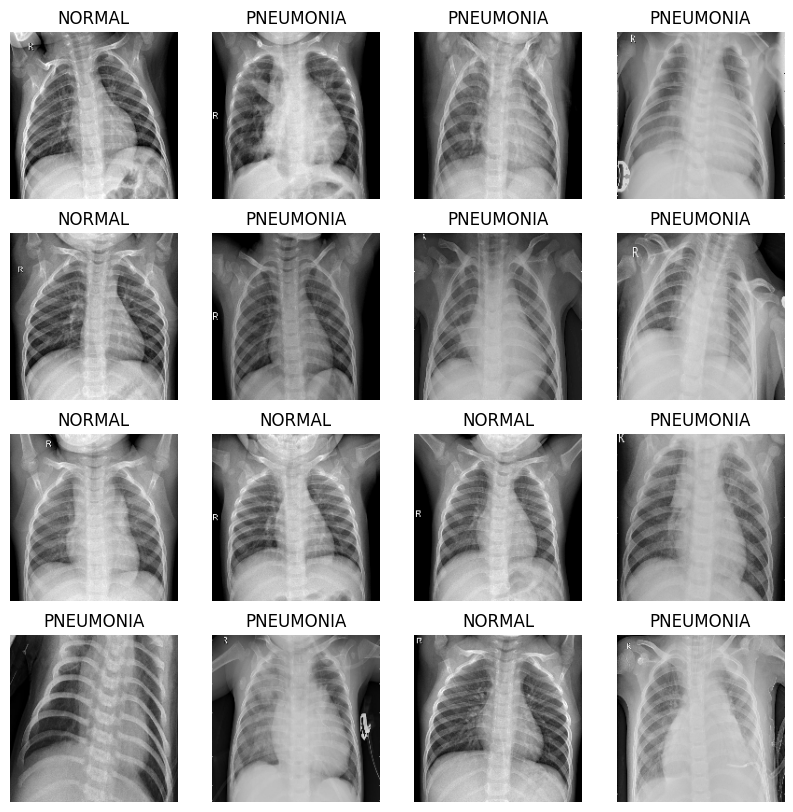

In [11]:
# TensorFlow 데이터셋을 훈련 가능한 형태로 준비하는 함수
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 데이터셋을 섞는다
    ds = ds.repeat()  # 데이터셋을 반복
    ds = ds.batch(BATCH_SIZE)  # 배치 크기만큼 데이터셋을 나눈다
    ds = ds.prefetch(buffer_size=AUTOTUNE)  # 학습 중 다음 배치를 미리 준비한다
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# train에 있는 batch 중 첫 번째 배치를 추출한다
# 추출된 배치를 image와 label 데이터 셋으로 나누고 이미지를 출력한다.
# 시간이 오래걸린다...
# 런타임 에러 런타임 연결 및 해제를 하고 다시 컴파일해야 실행이 되었다...

# 이미지 배치와 라벨 배치를 시각화하는 함수
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))  # 전체 그림의 크기 설정
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)  # 여러 개의 subplot 중 하나를 설정
        plt.imshow(image_batch[n])  # 이미지를 출력
        if label_batch[n]:  # 라벨이 1인 경우 (폐렴 이미지인 경우)
            plt.title("PNEUMONIA")
        else:  # 라벨이 0인 경우 (정상 이미지인 경우)
            plt.title("NORMAL")
        plt.axis("off")  # 축을 표시하지 않음

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델

In [12]:
# conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding 해결하고 Max Pooling을 한다.
def conv_block(filters):
    # 컨볼루션 블록을 정의하는 함수
    # 입력된 필터 수에 따라 블록을 생성

    block = tf.keras.Sequential([
        # 첫 번째 SeparableConv2D 레이어: 입력 채널과 필터의 깊이를 분리하여 연산을 수행
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),

        # 두 번째 SeparableConv2D 레이어: 추가적인 깊이 분리 컨볼루션 연산을 수행
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),

        # BatchNormalization 레이어: 각 배치의 평균과 분산을 정규화하여 학습 속도를 향상시킴
        tf.keras.layers.BatchNormalization(),

        # MaxPooling2D 레이어: 특성 맵의 공간 크기를 줄이고 주요 특성을 추출
        tf.keras.layers.MaxPool2D()
    ])

    return block  # 생성된 블록을 반환

# Dense Block 생성
def dense_block(units, dropout_rate):
    # 밀집 블록을 정의하는 함수
    # 입력된 유닛 수와 드롭아웃 비율에 따라 블록을 생성

    block = tf.keras.Sequential([
        # Dense 레이어: 완전 연결 층을 생성하고, 활성화 함수로 ReLU를 사용
        tf.keras.layers.Dense(units, activation='relu'),

        # BatchNormalization 레이어: 각 배치의 평균과 분산을 정규화하여 학습 속도를 향상시킴
        tf.keras.layers.BatchNormalization(),

        # Dropout 레이어: 드롭아웃 비율에 따라 일부 뉴런을 무작위로 제외하여 과적합을 방지
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block  # 생성된 블록을 반환

# Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용된 모
def build_model():
    # Sequential 모델을 생성
    model = tf.keras.Sequential([
        # 입력 레이어: 이미지 크기 (180, 180, 3)으로 입력을 받는다
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        # 첫 번째 컨볼루션 레이어: 16개의 필터, 3x3 커널 크기, ReLU 활성화 함수, 'same' 패딩
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        # 두 번째 컨볼루션 레이어: 16개의 필터, 3x3 커널 크기, ReLU 활성화 함수, 'same' 패딩
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        # 최대 풀링 레이어: 특성 맵의 크기를 줄인다
        tf.keras.layers.MaxPool2D(),

        # 컨볼루션 블록을 사용하여 더 깊은 네트워크를 구성한다.
        conv_block(32),  # 32개의 필터를 사용하는 컨볼루션 블록
        conv_block(64),  # 64개의 필터를 사용하는 컨볼루션 블록

        # 추가적인 컨볼루션 블록과 드롭아웃 레이어
        conv_block(128),  # 128개의 필터를 사용하는 컨볼루션 블록
        tf.keras.layers.Dropout(0.2),  # 20% 드롭아웃

        # 더 깊은 컨볼루션 블록과 드롭아웃 레이어
        conv_block(256),  # 256개의 필터를 사용하는 컨볼루션 블록
        tf.keras.layers.Dropout(0.2),  # 20% 드롭아웃

        # 완전 연결 층으로 변환하기 위해 평탄화한다.
        tf.keras.layers.Flatten(),

        # 밀집 블록을 사용하여 완전 연결 층을 구성한다.
        dense_block(512, 0.7),  # 512 유닛, 70% 드롭아웃을 사용하는 밀집 블록
        dense_block(128, 0.5),  # 128 유닛, 50% 드롭아웃을 사용하는 밀집 블록
        dense_block(64, 0.3),  # 64 유닛, 30% 드롭아웃을 사용하는 밀집 블록

        # 출력 레이어: 1개의 유닛, 시그모이드 활성화 함수
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model  # 모델을 반환

In [13]:
# 클래스 가중치를 계산하여 데이터 불균형 문제를 완화

# 'NORMAL' 클래스의 가중치 계산
# COUNT_NORMAL: 정상 이미지의 개수
# TRAIN_IMG_COUNT: 전체 훈련 이미지의 개수
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0

# 'PNEUMONIA' 클래스의 가중치 계산
# COUNT_PNEUMONIA: 폐렴 이미지의 개수
# TRAIN_IMG_COUNT: 전체 훈련 이미지의 개수
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

# 클래스 가중치를 딕셔너리 형태로 저장
class_weight = {0: weight_for_0, 1: weight_for_1}

# 각 클래스에 대한 가중치를 출력
print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

정상 이미지 클래스의 가중치: 1.95
폐렴 이미지 클래스의 가중치: 0.67


# 모델 훈련

In [17]:
# GPU를 사용하여 모델 설정
with tf.device('/GPU:0'):
    # 모델 빌드
    model = build_model()

    # 평가 지표 설정
    METRICS = [
        'accuracy',  # 정확도
        tf.keras.metrics.Precision(name='precision'),  # 정밀도
        tf.keras.metrics.Recall(name='recall')  # 재현율
    ]

    # 모델 컴파일
    model.compile(
        optimizer='adam',  # Adam 옵티마이저 사용
        loss='binary_crossentropy',  # 이진 교차 엔트로피 손실 함수
        metrics=METRICS  # 평가 지표
    )

# LMS에서는 잘 아래 데이터 형변환없이 잘 실행되었는데...구글 코렙에서는 실행이 안되었다...
# GPT와 씨름한결과 아래 구문을 추가하라는 답을 얻었다..
# 잘 실행된다..
# bool 타입의 라벨 데이터를 정수형으로 변환한다.

train_ds = train_ds.map(lambda image, label: (image, tf.cast(label, tf.int32)))
val_ds = val_ds.map(lambda image, label: (image, tf.cast(label, tf.int32)))

# GPU를 사용하여 모델 학습
# 시간이 너무 오래걸린다...
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 414s 1s/step - loss: 0.3990 - accuracy: 0.7864 - precision: 0.9500 - recall: 0.7526 - val_loss: 0.5851 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 102s 390ms/step - loss: 0.2163 - accuracy: 0.9171 - precision: 0.9778 - recall: 0.9091 - val_loss: 1.2422 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 89s 340ms/step - loss: 0.1990 - accuracy: 0.9229 - precision: 0.9801 - recall: 0.9152 - val_loss: 0.1103 - val_accuracy: 0.9654 - val_precision: 0.9906 - val_recall: 0.9620
Epoch 4/10
261/261 [==============================] - 104s 401ms/step - loss: 0.1821 - accuracy: 0.9272 - precision: 0.9791 - recall: 0.9216 - val_loss: 0.2155 - val_accuracy: 0.9163 - val_precision: 0.9985 - val_recall: 0.8876
Epoch 5/10
261/261 [==============================] - 106s 406ms/step - loss: 0.1872 - accur

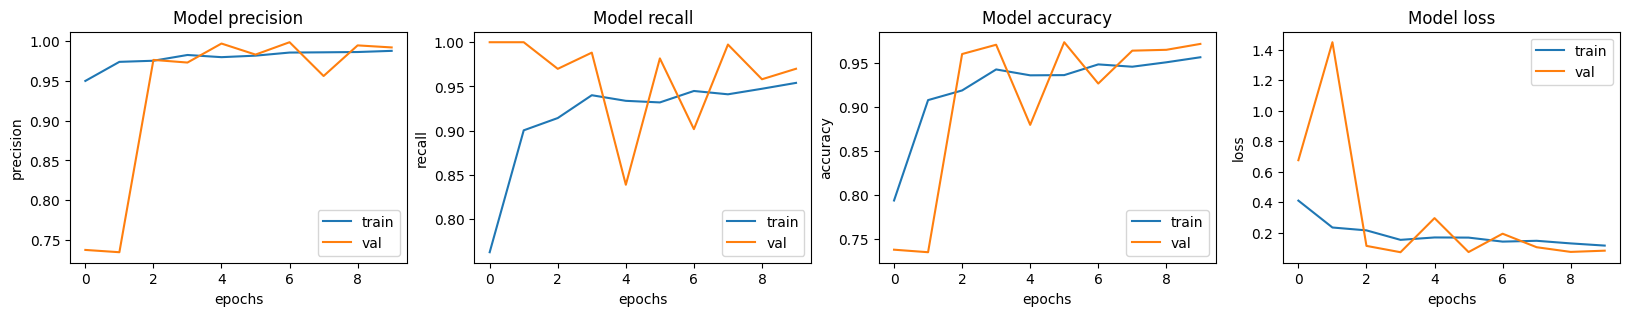

In [24]:
# 1x4 서브플롯을 생성
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

# 정밀도, 재현율, 정확도, 손실을 차례로 그래프
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    # 훈련 데이터셋과 검증 데이터셋에 대한 각 지표의 값을 그래프로 표시한다.
    ax[i].plot(history.history[met])  # 훈련 데이터셋의 해당 지표 값
    ax[i].plot(history.history['val_' + met])  # 검증 데이터셋의 해당 지표 값
    ax[i].set_title('Model {}'.format(met))  # 그래프 제목 설정
    ax[i].set_xlabel('epochs')  # x축 레이블 설정
    ax[i].set_ylabel(met)  # y축 레이블 설정
    ax[i].legend(['train', 'val'])  # 범례 추가: 'train'은 훈련 데이터셋, 'val'은 검증 데이터셋

# 결과

In [26]:
# 테스트 데이터셋을 사용하여 모델을 평가하고 결과를 출력

# 테스트 데이터셋을 사용하여 모델을 평가하고 손실, 정확도, 정밀도, 재현율 값을 계산
loss, accuracy, precision, recall = model.evaluate(test_ds)

# 계산된 값들을 출력
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 186ms/step - loss: 0.5618 - accuracy: 0.8478 - precision: 0.8105 - recall: 0.9872
Loss: 0.5617650747299194,
Accuracy: 0.8477563858032227,
Precision: 0.8105263113975525,
Recall: 0.9871794581413269


# RESNET

In [72]:
# 하다가 에러, 에러, 에러 포기했습니다. ㅠ

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'to'

# 회고

1. 코렙에서 코드를 실행할려고 Kaggle에서 데이터셋을 다운받아서 구글 드라이브에 업로드 하는데 시간이 1시간정도 소요되었다.
2. 이미지 배치 및 시각화하는데 시간도 10분정도 소요되고, 런타임 에러가 걸려
런타임 해제 및 삭제를 하여 초기화 하고 다시 컴파일 하니 에러없이 잘 실행이 되었다.
3. CNN모델을 적용하고 모델훈련자체도 20분정도 소요된다. 2번 같은 코드로 2번 훈련하였더니 결과는 더 좋게 나왔었다.
4. 전체적으로 시간도 많이 소요되고, 어렵기도 했었다.
5. 모델 훈련하는 과정에서 LMS에서는 잘 실행되었었는데 코렙에서는 계속 에러가 뜨고 실행이 안되는 구문이 있었다. bool 타입의 라벨 데이터를 정수형으로 변환하는 코드인데 LMS에서는 없었는데 구글 코렙에서  GPT의 도움을 받아 추가하였더니 에러없이 잘 실행되었다.(이 과정도 1시간정도 헤매었습니다.)